In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import *
from pmdarima.preprocessing import BoxCoxEndogTransformer
from scipy import stats
import numpy as np
import pmdarima as pm
from scipy.stats import shapiro as sw
from statsmodels.stats.stattools import durbin_watson as db
from statsmodels.stats.diagnostic import het_breuschpagan as bp
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [2]:
hedgefund=pd.read_csv('returnsant.csv')['Hedge Fund'][0:48]

In [3]:
hedgefund2=pd.read_csv('returnsant.csv')['Hedge Fund']

In [4]:
class timeseriesstuff():
    def __init__(self,x):
        self.x=x
    def seasonalplustrenddecomp(self,tperiod):
        decomp = STL(self.x,period=tperiod).fit()
        decomp.plot()
        plt.show()
        return decomp.seasonal,decomp.trend
        
    def acfandpacf(self,name):
        plot_acf(self.x,title="acf"+name)
        plot_pacf(self.x,title="pacf"+name,method='ywmle')
        plt.show()

In [5]:
class resanalysis():
    def __init__(self,res,exog):
        self.res=res
        self.var=res**2
        self.exog=exog
    
    def densityplot(self):
        pd.DataFrame(self.res).plot(kind='kde',title='residual')
        pd.DataFrame(self.var).plot(kind='kde',title='variance')
    def boxjawn(self):
        pd.DataFrame(self.res).plot(kind='box',title='residual')
        pd.DataFrame(self.var).plot(kind='box',title='variance')
        
    
    def homotest(self):
        pvaluef=bp(self.res,self.exog)[3]
        if pvaluef > 0.05:
            print('The null hypothesis that the residuals are homogenous is accepted under alpha= 0.05 with p-value{}'.format(pvaluef))
    
    def serialtest(self):    
        dbtest=db(self.res)
        print("Test statistic for Durbin Watson is {} should be ~2".format(dbtest))
    
    def normalitytest(self):
        swtest=sw(self.res)[1]
        if swtest > 0.05:
            print(' The null hypothesis that the sampled population follows approximately normal is accepted{}'.format(swtest))

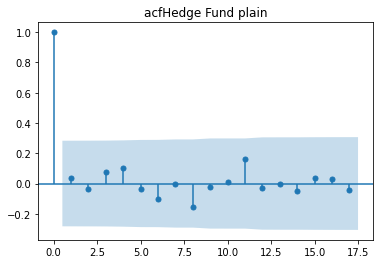

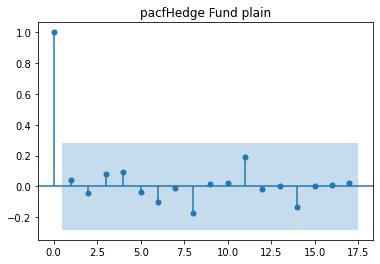

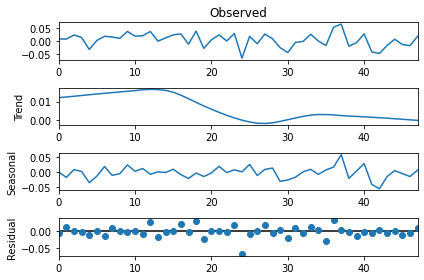

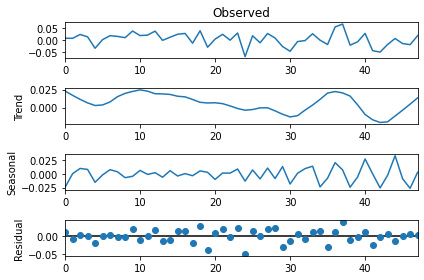

In [6]:
ts=timeseriesstuff(hedgefund.values.reshape(-1,1))
ts.acfandpacf('Hedge Fund plain')
ds=[12,4]
for d in ds:
    seasonality, trendy = ts.seasonalplustrenddecomp(d)
    seasonality=pd.Series(seasonality)
    trendy=pd.Series(trendy)
    regress=hedgefund - seasonality - trendy

([<matplotlib.axis.XTick at 0x7f9208311f10>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

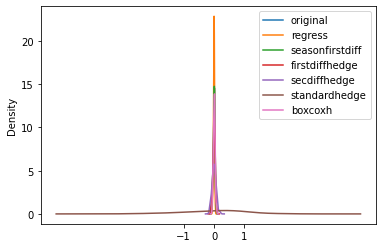

In [7]:
fig,ax=plt.subplots()
#loghedge=pd.DataFrame(np.log(hedgefund.values))
seasonfirstdiff=regress.diff().dropna()
firstdiffhedge=hedgefund.diff().dropna()
secdiffhedge=firstdiffhedge.diff().dropna()
standardhedge=pd.DataFrame(StandardScaler().fit_transform(hedgefund.values.reshape(-1,1)))
hedgeplusthree=hedgefund + 3
boxcoxh=BoxCoxEndogTransformer().fit_transform(hedgefund.values.reshape(-1,1)+1)[0]
boxcoxh=pd.DataFrame(boxcoxh)
#boxcoxhedge=pd.DataFrame(stats.boxcox((hedgeplusthree.values)))
loghedge=pd.DataFrame(np.log(hedgeplusthree.values.reshape(-1,1)))
exphedge=pd.DataFrame(np.exp(hedgefund.values.reshape(-1 , 1)))

hedgefund.plot(kind='kde',ax=ax)

regress.plot(kind='kde',ax=ax)

seasonfirstdiff.plot(kind='kde',ax=ax)

firstdiffhedge.plot( kind='kde',ax=ax)

secdiffhedge.plot( kind='kde',ax=ax)

standardhedge.plot( kind='kde',ax=ax)

boxcoxh.plot( kind='kde',ax=ax)

transformed=[hedgefund,regress,seasonfirstdiff,firstdiffhedge,secdiffhedge,standardhedge, boxcoxh]
transnames=['original','regress','seasonfirstdiff','firstdiffhedge','secdiffhedge','standardhedge','boxcoxh']
ax.legend(transnames)
plt.xticks([-1,0,1])

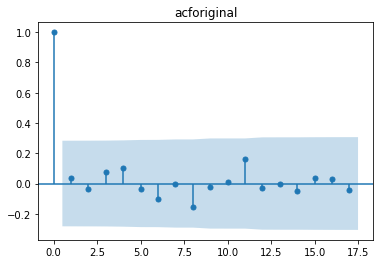

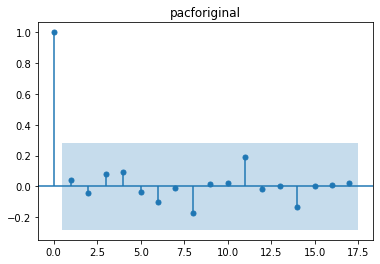

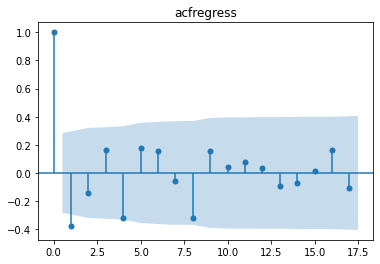

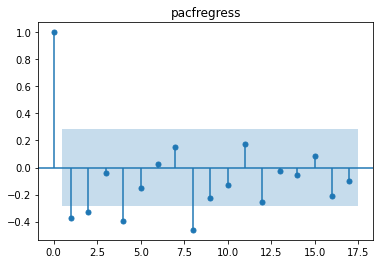

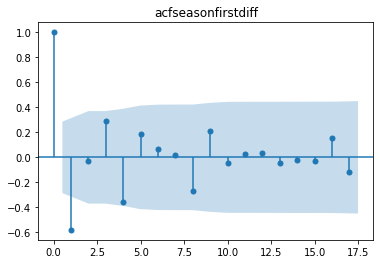

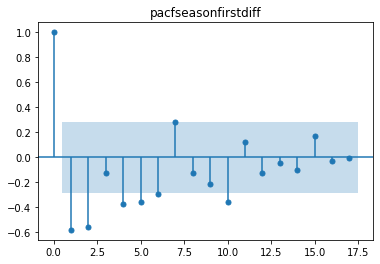

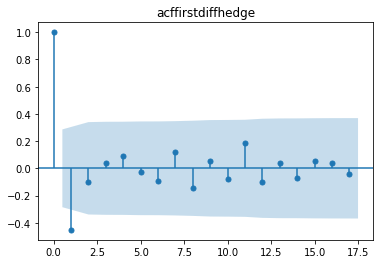

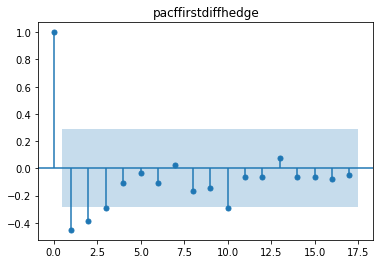

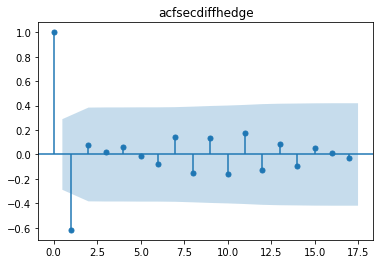

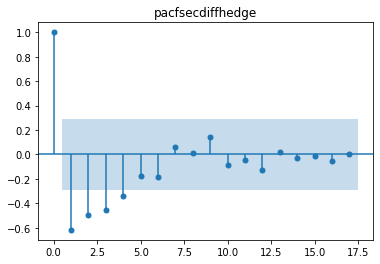

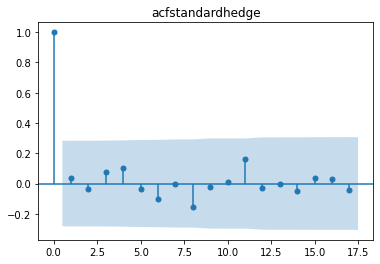

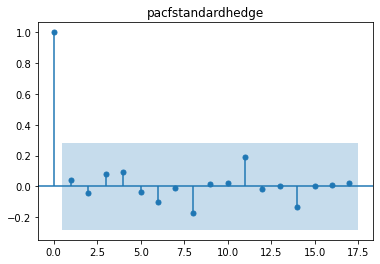

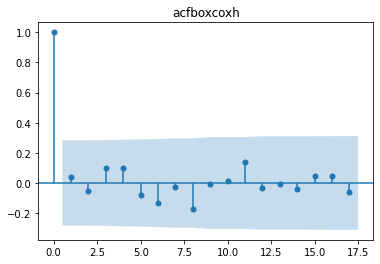

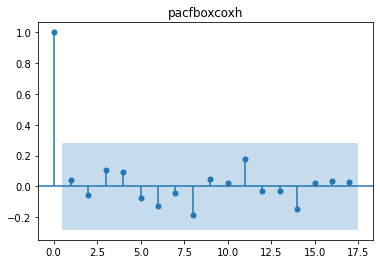

,pvalue
original,5.190063e-08
regress,8.801344e-05
seasonfirstdiff,7.399473e-06
firstdiffhedge,1.793943e-09
secdiffhedge,2.975347e-06
standardhedge,1.679643e-08
boxcoxh,1.875125e-08


In [8]:
tsl=[]
i=0
for t,n in zip(transformed,transnames):
    tsl.append(timeseriesstuff(t))
    tsl[i].acfandpacf(n)
    i+=1

#loghedge.plot(kind='kde',ax=ax)
#plot_acf(loghedge.values,title='acf '+transnames[6])
#plot_pacf(loghedge.values,title='pacf '+transnames[6])

#exphedge.plot(kind='kde',ax=ax)
#plot_acf(exphedge.values,title='acf '+transnames[7])
#plot_pacf(exphedge.values,title='pacf '+transnames[7])
adfres=[]
missingvalexp=[]
for t,transname in zip(transformed,transnames):
    missingvalexp.append(t.isnull().sum())
    
    if transname=='original':
        adfres.append(adfuller(t.dropna().values.reshape(-1,1),regression='ct')[1])
    elif (transname=='regress')|(transname=='seasonfirstdiff'):
         adfres.append(adfuller(t.dropna().values.reshape(-1,1),regression='nc')[1])
    else:
        adfres.append(adfuller(t.dropna().values.reshape(-1,1))[1])
        continue
#missingvalexp=np.array(missingvalexp).reshape(len(transnames),1,dtype='O')
adfres=np.array(adfres).reshape(len(transnames),1)
adfrespd=pd.DataFrame(adfres)
#adfrespd['Stationary Values BOOL']=
#adfrespd['Missing Values BOOL']=missingvalexp
adfrespd.index=transnames
adfrespd.columns=['pvalue']
adfrespd.head(len(transnames))

In [9]:
y_train=hedgefund[0:36]
y_test=hedgefund[36:48]
dlist=[0,1,2]
mlist=[1,4]
for m in mlist:
    for d in dlist:
  
        stepwise_fit = pm.auto_arima(y_train.values.reshape(-1,1), start_p=1, start_q=1,
                             max_p=3, max_q=3, m=m,
                             start_P=0, seasonal=True,
                             d=d, D=0, trace=True,
                             error_action='trace',
                             suppress_warnings=False, 
                             stepwise=True) 
        stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-159.830, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-163.214, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-161.497, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-161.448, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-162.664, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.124 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-130.814, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-143.728, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-132.798, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-143.432, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-151.560, Time=0.11 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-150.384, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-151.754, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-149.680, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-150.948, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-151.711, Time=0.04 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 0.825 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-88.633, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-115.005, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-119.675, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-119.295, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-133.266, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-132.988, Time=0.07 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-139.520, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-140.423, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-138.712, Time=0.07 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.08 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-138.446, Time=0.04 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.680 seconds
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=-157.835, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=-163.214, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=-159.531, Time=0.02 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=-159.503, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=-162.664, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=-161.224, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=-161.231, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=-161.497, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=-161.448, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=-159.830, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[4] intercept
Total fit time: 0.345 seconds
Performing stepw

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=-151.818, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-130.814, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-142.644, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-152.988, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-132.798, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.04 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=-154.106, Time=0.10 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=-152.192, Time=0.13 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=-129.607, Time=0.04 sec
 ARIMA(1,1,1)(0,0,2)[4] intercept   : AIC=-152.937, Time=0.17 sec
 ARIMA(0,1,2)(0,0,2)[4] intercept   : AIC=-153.372, Time=0.14 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


 ARIMA(1,1,0)(0,0,2)[4] intercept   : AIC=-145.274, Time=0.09 sec
 ARIMA(1,1,2)(0,0,2)[4] intercept   : AIC=-152.129, Time=0.17 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,2)[4]             : AIC=-153.451, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,2)[4] intercept
Total fit time: 1.307 seconds
Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,1)[4]             : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=-88.633, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=-114.798, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=-115.005, Time=0.02 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=-117.867, Time=0.06 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=-116.308, Time=0.07 sec
 ARIMA(1,2,0)(0,0,2)[4]             : AIC=-116.811, Time=0.10 sec


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving avera

 ARIMA(1,2,0)(1,0,2)[4]             : AIC=-115.088, Time=0.10 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=-86.664, Time=0.02 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=-113.965, Time=0.05 sec
 ARIMA(2,2,1)(0,0,1)[4]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=-115.974, Time=0.09 sec

Best model:  ARIMA(1,2,0)(0,0,1)[4]          
Total fit time: 0.794 seconds


In [10]:
firstmodel=pm.arima.ARIMA((0,2,2),(0,0,0,0),trace= True)
firstmodel.fit(y_train.values.reshape(-1,1))
firstmodel.summary()

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 2, 2)   Log Likelihood                  73.223
Date:                Fri, 30 Dec 2022   AIC                           -138.446
Time:                        23:58:14   BIC                           -132.340
Sample:                             0   HQIC                          -136.364
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.816e-05      0.000     -0.138      0.890      -0.001       0.001
ma.L1         -1.8232      0.205     -8.873      0.000      -2.226      -1.420
ma.L2          0.8876      0.209      4.252      0.000       0.478       1.297
sigma2         0.0007      0.000      3.240      0.001       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                 3.36
Prob(Q):                              0.42   Prob(JB):                         0.19
Heteroskedasticity (H):               2.02   Skew:                            -0.75
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


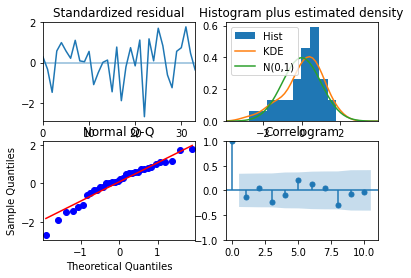

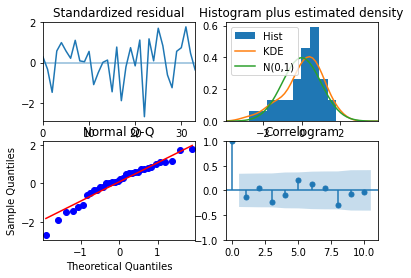

In [11]:
firstmodel.plot_diagnostics()

The null hypothesis that the residuals are homogenous is accepted under alpha= 0.05 with p-value0.10643995377100832
Test statistic for Durbin Watson is 2.215370503877096 should be ~2
 The null hypothesis that the sampled population follows approximately normal is accepted0.07328327000141144


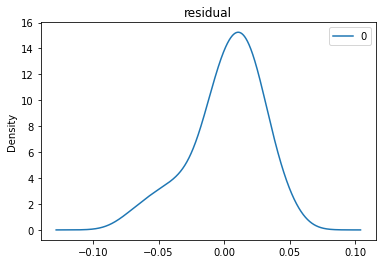

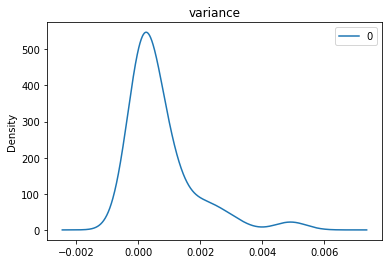

In [12]:
resid=resanalysis(firstmodel.resid(),hedgefund.values.reshape(-1,1)[0:36])
resid.densityplot()
resid.homotest()
resid.serialtest()
resid.normalitytest()

In [13]:
len(firstmodel.resid())

36

In [14]:
y_test

36    0.0550
37    0.0672
38   -0.0198
39   -0.0061
40    0.0287
41   -0.0423
42   -0.0484
43   -0.0169
44    0.0077
45   -0.0132
46   -0.0177
47    0.0190
Name: Hedge Fund, dtype: float64

In [15]:
def forecast_one_step(model):
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

robustnumberone=firstmodel
forecastsrobust=[]
confidence_intervalsrobust=[]

for new_ob in y_test.values:
    
    fc,conf = forecast_one_step(robustnumberone)
    forecastsrobust.append(fc)
    confidence_intervalsrobust.append(conf)
    
    
    robustnumberone.update(new_ob)
forecastsrobust=np.array(forecastsrobust)
confidence_intervalsrobust=np.array(confidence_intervalsrobust)

print(f"Mean squared error: {mean_squared_error(y_test, forecastsrobust)}")
print(f"SMAPE: {smape(y_test, forecastsrobust)}")

Mean squared error: 0.0019781510493870297
SMAPE: 152.75042408092625


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/s

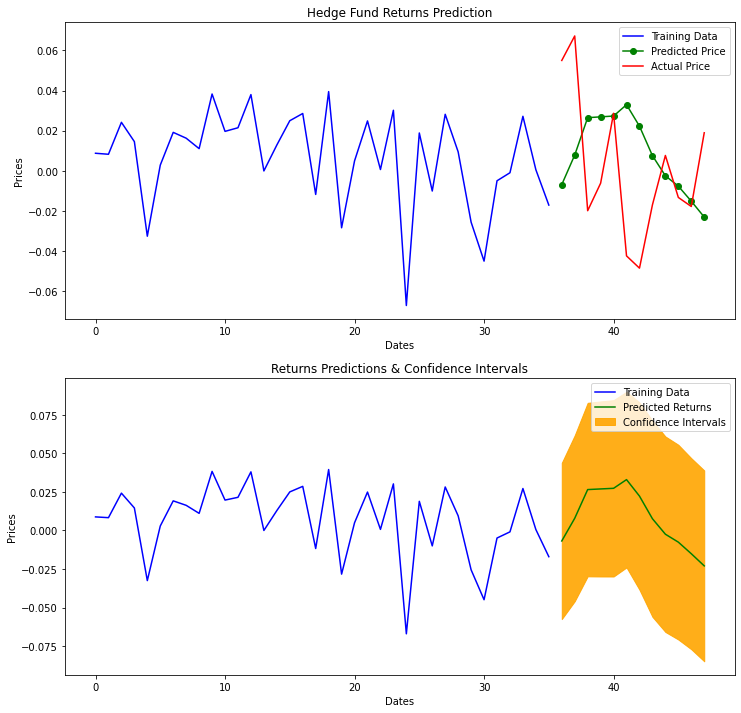

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

#Actual vs. Predicted
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(hedgefund.index[36:48], forecastsrobust, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(hedgefund.index[36:48], y_test, color='red', label='Actual Price')
axes[0].set_title('Hedge Fund Returns Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].legend()


# Predicted with confidence intervals
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(hedgefund.index[36:48], forecastsrobust, color='green',
             label='Predicted Returns')

axes[1].set_title('Returns Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')


axes[1].fill_between(hedgefund.index[36:48],
                     confidence_intervalsrobust[:, 0], confidence_intervalsrobust[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")


axes[1].legend()

Test statistic for Durbin Watson is 1.7446787315211836 should be ~2
 The null hypothesis that the sampled population follows approximately normal is accepted0.21441525220870972


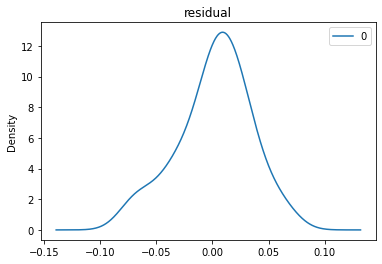

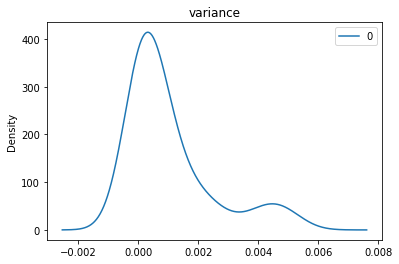

In [17]:
resid2=resanalysis(robustnumberone.resid(),hedgefund.values.reshape(-1,1)[0:59])
resid2.densityplot()
#
resid2.serialtest()
resid2.normalitytest()

# Analysis of second model the residuals are not satisfactory for the model above
- consider the AIC of the stepwise summary loop

In [18]:
secondmodel=pm.arima.ARIMA((0,1,1),(0,0,2,4),trace= True)
secondmodel.fit(y_train.values.reshape(-1,1))
secondmodel.summary()

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                  82.053
Date:                                Fri, 30 Dec 2022   AIC                           -154.106
Time:                                        23:58:15   BIC                           -146.329
Sample:                                             0   HQIC                          -151.421
                                                 - 36                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.000     -1.910      0.056      -0.001    1.74e-05
ma.L1         -0.9537      0.289     -3.295      0.001      -1.521      -0.386
ma.S.L4       -0.1529      0.338     -0.453      0.651      -0.815       0.509
ma.S.L8       -0.3197      0.294     -1.087      0.277      -0.896       0.257
sigma2         0.0005      0.000      2.445      0.015    9.24e-05       0.001
===================================================================================
Ljung-Box (L1) (Q):                   2.13   Jarque-Bera (JB):                10.82
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                            -1.16
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


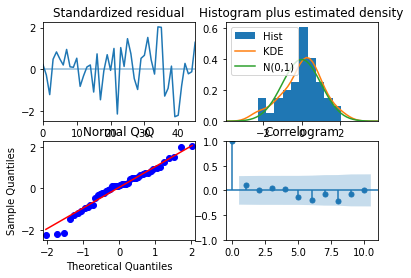

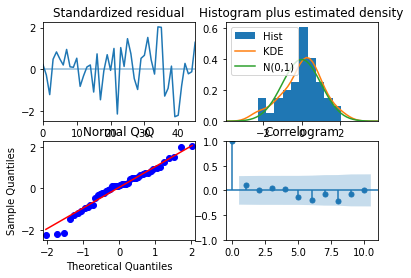

In [19]:
firstmodel.plot_diagnostics()

Test statistic for Durbin Watson is 2.411021605881028 should be ~2


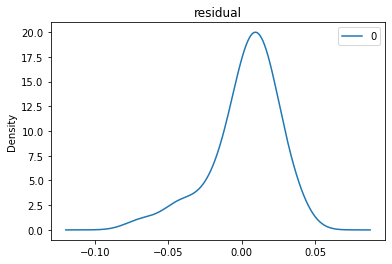

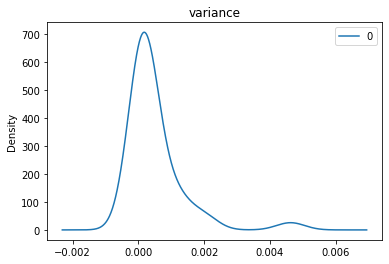

In [20]:
resid3=resanalysis(secondmodel.resid(),hedgefund.values.reshape(-1,1)[0:36])
resid3.densityplot()
resid3.homotest()
resid3.serialtest()
resid3.normalitytest()

In [21]:
robustnumberone2=secondmodel
forecastsrobust2=[]
confidence_intervalsrobust2=[]

for new_ob in y_test.values.reshape(-1,1):
    
    fc,conf = forecast_one_step(robustnumberone2)
    forecastsrobust2.append(fc)
    confidence_intervalsrobust2.append(conf)
    
    
    robustnumberone2.update(new_ob)
forecastsrobust2=np.array(forecastsrobust2)
confidence_intervalsrobust2=np.array(confidence_intervalsrobust2)

print(f"Mean squared error: {mean_squared_error(y_test, forecastsrobust2)}")
print(f"SMAPE: {smape(y_test, forecastsrobust2)}")

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/s

Mean squared error: 0.0014719157504385204
SMAPE: 170.96493880000193


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/s

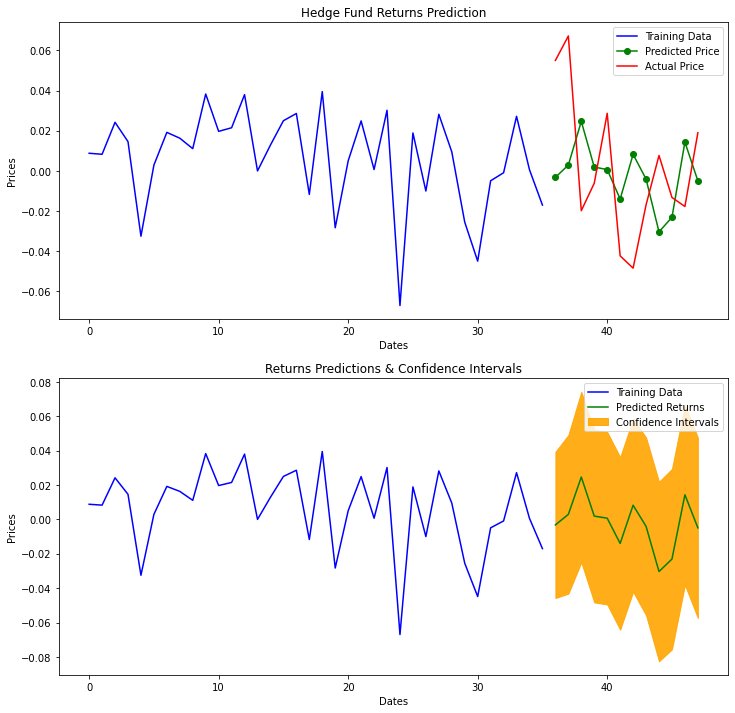

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

#Actual vs. Predicted
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(hedgefund.index[36:48], forecastsrobust2, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(hedgefund.index[36:48], y_test, color='red', label='Actual Price')
axes[0].set_title('Hedge Fund Returns Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].legend()
axes[0].legend()


# Predicted with confidence intervals
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(hedgefund.index[36:48], forecastsrobust2, color='green',
             label='Predicted Returns')

axes[1].set_title('Returns Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')


axes[1].fill_between(hedgefund.index[36:48],
                     confidence_intervalsrobust2[:, 0], confidence_intervalsrobust2[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")


axes[1].legend()

Test statistic for Durbin Watson is 2.1440866307507496 should be ~2
 The null hypothesis that the sampled population follows approximately normal is accepted0.4085114598274231


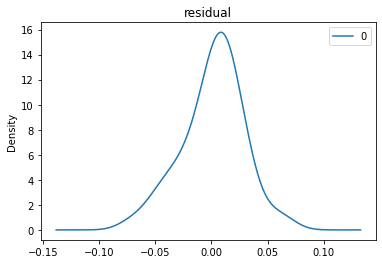

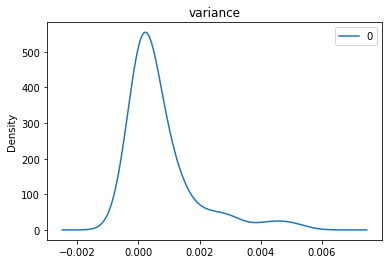

In [23]:
resid4=resanalysis(robustnumberone2.resid(),hedgefund.values.reshape(-1,1)[0:48])
resid4.densityplot()
#resid4.homotest()
resid4.serialtest()
resid4.normalitytest()

# Consider testing the next 12 values and confirming robustness

In [24]:
y_test3=hedgefund2[48:60]
robustnumberone3=robustnumberone2
forecastsrobust3=[]
confidence_intervalsrobust3=[]

for new_ob in y_test3.values.reshape(-1,1):
    
    fc,conf = forecast_one_step(robustnumberone3)
    forecastsrobust3.append(fc)
    confidence_intervalsrobust3.append(conf)
    
    
    robustnumberone3.update(new_ob)
forecastsrobust3=np.array(forecastsrobust3)
confidence_intervalsrobust3=np.array(confidence_intervalsrobust3)

print(f"Mean squared error: {mean_squared_error(y_test3, forecastsrobust3)}")
print(f"SMAPE: {smape(y_test3, forecastsrobust3)}")

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/s

Mean squared error: 0.0009901999038856193
SMAPE: 153.32443064817468


/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


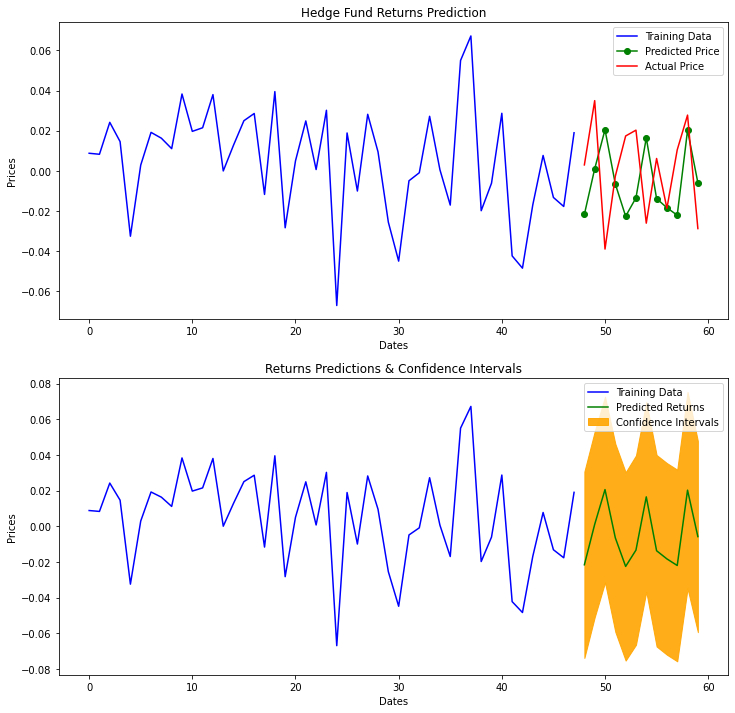

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

#Actual vs. Predicted
axes[0].plot(hedgefund2[0:48], color='blue', label='Training Data')
axes[0].plot(hedgefund2.index[48:60], forecastsrobust3, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(hedgefund2.index[48:60], hedgefund2[48:60], color='red', label='Actual Price')
axes[0].set_title('Hedge Fund Returns Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].legend()
axes[0].legend()


# Predicted with confidence intervals
axes[1].plot(hedgefund2[0:48], color='blue', label='Training Data')
axes[1].plot(hedgefund2.index[48:60], forecastsrobust3, color='green',
             label='Predicted Returns')

axes[1].set_title('Returns Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')


axes[1].fill_between(hedgefund2.index[48:60],
                     confidence_intervalsrobust3[:, 0], confidence_intervalsrobust3[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")


axes[1].legend()

In [26]:
len(robustnumberone3.resid())

60

# this model is robust!

In [27]:
robustnumberone3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                 126.586
Date:                                Fri, 30 Dec 2022   AIC                           -243.171
Time:                                        23:59:14   BIC                           -232.784
Sample:                                             0   HQIC                          -239.117
                                                 - 60                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.000     -1.827      0.068      -0.001    2.62e-05
ma.L1         -0.9537      0.190     -5.022      0.000      -1.326      -0.582
ma.S.L4       -0.1493      0.143     -1.042      0.297      -0.430       0.132
ma.S.L8       -0.3195      0.176     -1.819      0.069      -0.664       0.025
sigma2         0.0007      0.000      3.587      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 2.28
Prob(Q):                              0.45   Prob(JB):                         0.32
Heteroskedasticity (H):               2.77   Skew:                            -0.48
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
y_train3, y_test3= hedgefund2[0:60], hedgefund2[60:80]
def plot_results(y_train,y_test,forecastres,confidence_inter):
    fig, axes= plt.subplots(2, 1, figsize=(12,12))
    
    axes[0].plot(y_train, color='blue',label='Training Data')
    axes[0].plot(y_test.index, forecastres, color='green',marker='o',label='predicted price')
    axes[0].plot(y_test.index, y_test,color='red',label='Actual Price')
    
    axes[0].set_title('Hedge Fund Returns Prediction')
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Prices')
    
    axes[0].legend()
    # Conf int plot
    
    axes[1].plot(y_train,color='blue',label='Training Data')
    axes[1].plot(y_test.index,forecastres,color='green',label='Predicted Returns')
    
    axes[1].set_title('Returns Predictions & Confidence Intervals')
    axes[1].set_xlabel('Dates')
    axes[1].set_ylabel('Prices')
    
    axes[1].fill_between(y_test.index,confidence_inter[:,0],confidence_inter[:,1],
                        alpha=0.9, color='orange', label='confidence intervals')
    axes[1].legend()
    
    plt.show()
                
                 
def test_steps_forecast(y_train,y_test,model):
    forecastres=[]
    confidence_inter=[]
    for new_ob in y_test:
        
        fc, conf= forecast_one_step(model)
        forecastres.append(fc)
        confidence_inter.append(conf)
        
        model.update(new_ob)
        
    forecastres=np.array(forecastres)
    confidence_inter=np.array(confidence_inter)
    plot_results(y_train,y_test,forecastres,confidence_inter)
    print(f"Mean squared error: {mean_squared_error(y_test, forecastres)}")
    print(f"SMAPE: {smape(y_test, forecastres)}")
    # model summary will not display with pyplot above
    #
    return forecastres,confidence_inter

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/s

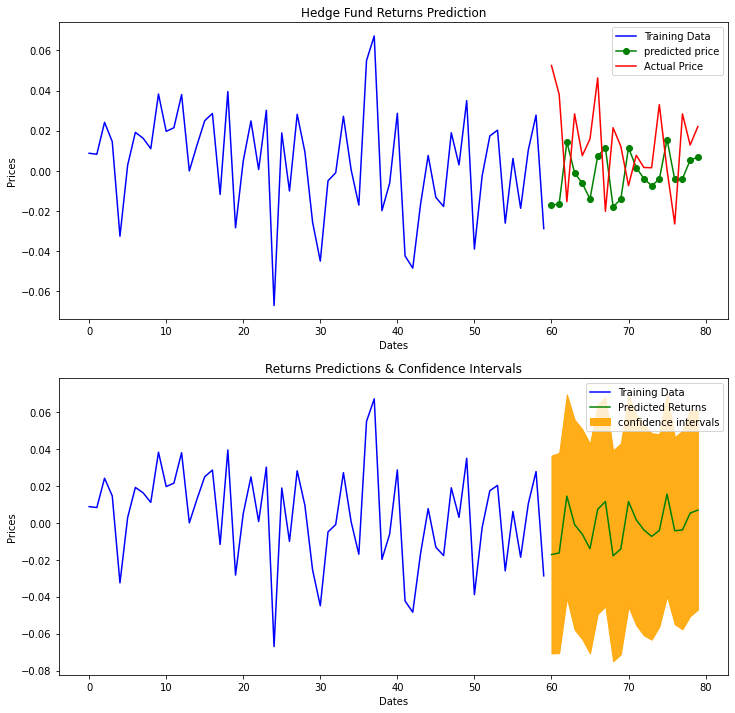

Mean squared error: 0.0009668879605044553
SMAPE: 179.72055923070698


In [29]:
forecastrobust4, confidence_intervalsrobust4=test_steps_forecast(y_train3, y_test3, robustnumberone3)

In [30]:
robustnumberone3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   80
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                 170.083
Date:                                Sat, 31 Dec 2022   AIC                           -330.167
Time:                                        00:00:03   BIC                           -318.320
Sample:                                             0   HQIC                          -325.421
                                                 - 80                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -2.67e-05      0.000     -0.158      0.874      -0.000       0.000
ma.L1         -0.9537      0.070    -13.613      0.000      -1.091      -0.816
ma.S.L4       -0.1333      0.119     -1.122      0.262      -0.366       0.099
ma.S.L8       -0.2684      0.113     -2.381      0.017      -0.489      -0.047
sigma2         0.0008      0.000      5.658      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.47   Prob(JB):                         0.25
Heteroskedasticity (H):               1.42   Skew:                            -0.46
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test statistic for Durbin Watson is 2.149205375925134 should be ~2
 The null hypothesis that the sampled population follows approximately normal is accepted0.12048904597759247


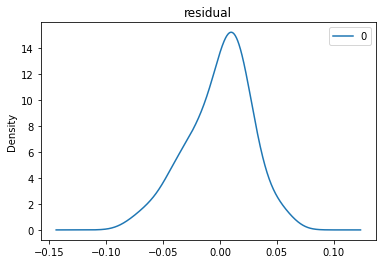

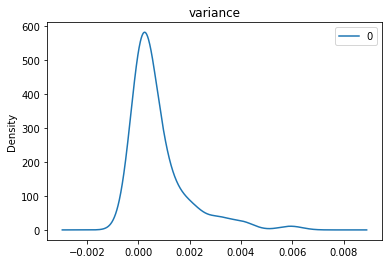

In [32]:
resid5=resanalysis(robustnumberone3.resid(),hedgefund2[0:80])
resid5.densityplot()
#resid4.homotest()
resid5.serialtest()
resid5.normalitytest()

/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/teacher/opt/anaconda3/lib/python3.9/s

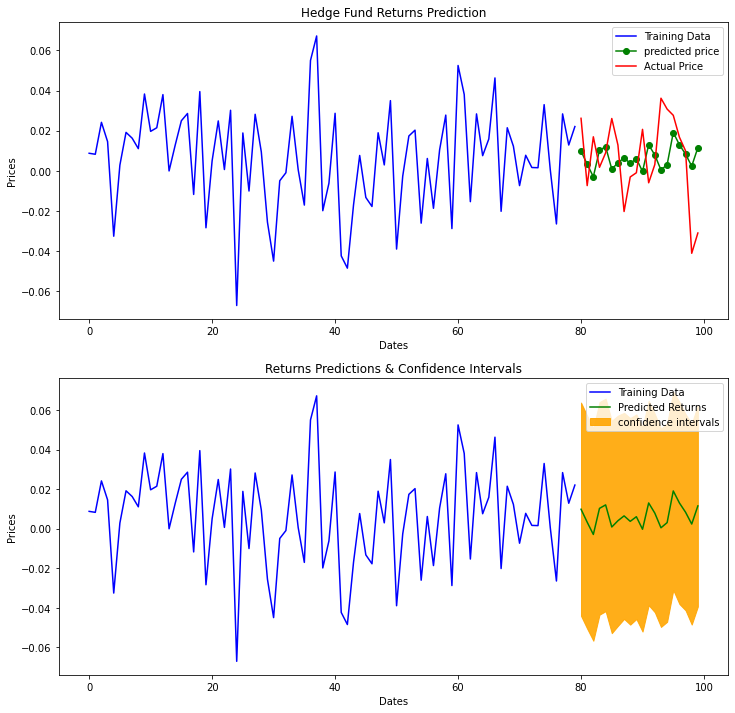

Mean squared error: 0.00045078594383382315
SMAPE: 143.67090869173524


In [34]:
y_train4, y_test4 = hedgefund2[0:80], hedgefund2[80:100]
forecastrobust5, confidence_intervalsrobust5=test_steps_forecast(y_train4, y_test4, robustnumberone3)

In [35]:
robustnumberone3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 4)   Log Likelihood                 218.314
Date:                                Sat, 31 Dec 2022   AIC                           -426.629
Time:                                        00:08:03   BIC                           -413.653
Sample:                                             0   HQIC                          -421.379
                                                - 100                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.246e-05      0.000     -0.202      0.840      -0.000       0.000
ma.L1         -0.9537      0.049    -19.440      0.000      -1.050      -0.858
ma.S.L4       -0.1311      0.103     -1.278      0.201      -0.332       0.070
ma.S.L8       -0.2606      0.097     -2.696      0.007      -0.450      -0.071
sigma2         0.0007      0.000      6.649      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 3.67
Prob(Q):                              0.72   Prob(JB):                         0.16
Heteroskedasticity (H):               0.79   Skew:                            -0.47
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""